# Customer Journey Analytics in E-commerce
Mapping the customer decision journey has become a crucial tool to help companies to win customers. According to a global survey of over 7,000 marketers and e-commerce professionals, 24% of respondents ranked the customer experience as the single most exciting opportunity ahead. And 78% agree that the customer experience creates brand differentiation and competitive advantage.

The successful journey mapping requires a healthy balance of qualitative and quantitative information on which an organization can act upon. While qualitative information is gathered based on the experience of customer-facing functions, the role of data scientist comes handy when supporting marketing with quantitative knowledge.

## 1. Business Understanding
The purpose of this project is to share with fellow data scientists, how they can support marketing and sales with quantitative analysis during customer journey mapping. What kind of ML algorithm to use to answer different marketing & sales questions like:
 1. How many buyer personas do we have?
 2. What are their unique characteristics?
 3. How accurately can we predict buyer persona from the first customer purchase transaction?
 4. How can we adapt the marketing strategy concerning buyer personas to increase ROI?
 
### 1.1 Buyer Personas
A buyer persona is a research-based representation of customers. It includes
demographics, such as age, gender, or geography
 - attitudes
 - behaviors
 - motivations

It describes who the customer is, their goals, their concerns, and how they think. It includes the decision criteria needed to addressed to win their business, such as how they
 - receive information
 - weigh and evaluate different options
 - when and where they decide to buy

So, a buyer persona is a profile of the customers who need to be engaged throughout their decision journey to drive their loyalty and advocacy as they choose a company brand over the competition. Buyer personas help better understand customers so the company can choose the right marketing touchpoints and message, and this will attract more social shares and increase brand rankings in search engines

### 1.2 Customer Journey
A customer journey shows the whole customer experience from initial brand awareness through purchase, and importantly after the purchase to reach customers at the moments that most influence their decisions.

These insights reveal which marketing touchpoints to use, such as search, a website, online banners, or a magazine ad, and guide what kind of messaging to communicate in each of those touchpoints to engage your customers. In that way, resources can be focused in the right places and the right information can be shared with customers.

As the scope is quite big I will narrow it from initial brand awareness to purchase.

### 1.3 Ecommerce Use Case
As most of the companies keep data related to customer journey confidential, the use case will be demonstrated on [Google Analytics Sample Dataset](https://support.google.com/analytics/answer/7586738?hl=en)

The sample dataset contains obfuscated Google Analytics 360 data from the [Google Merchandise Store](https://shop.googlemerchandisestore.com/), a real e-commerce store. The Google Merchandise Store sells Google-branded merchandise. The data is typical of what you would see for an e-commerce website. It includes the following kinds of information:
 - __Traffic source__ data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.
 - __Content__ data: information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc.
 - __Transactional data__: information about the transactions that occur on the Google Merchandise Store website.

In [1]:
# IMPORTS
# -------

# Standard libraries
from importlib import reload
import pathlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import itertools
import ipdb
import string
import re

# 3rd party imports
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

import scikit_posthocs as sp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from google.cloud import bigquery

# Local libraries
from bigquery_ import BigqueryTable
from bigquery_ import BigqueryDataset
import helper


# AUTHENTIFICATION & ACCESS
# -------------------------

# Supply your service account key
service_account = pathlib.Path(
    ('path/to/your/service/account/key')
)

# Authenticate and initiate biqquery client
client = bigquery.Client.from_service_account_json(service_account.absolute())

# Get dataset reference
project = 'bigquery-public-data'
dataset_id = 'google_analytics_sample'
dataset_ref = client.dataset(dataset_id, project=project)
dataset = BigqueryDataset(client, dataset_ref)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fredo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Understanding
Data can be accessed via BigQuery. They are stored in the form of daily tables from 1st Aug 2016 to 1st Aug 2017. As the dataset schema does not reveal any field description, it needs to be merged with [BigQuery Export Schema](https://support.google.com/analytics/answer/3437719?hl=en).

In [2]:
# Investigate dataset schema
display(dataset.schema.shape)
display(dataset.schema['table_name'].head(n=3))
display(dataset.schema['table_name'].tail(n=3))

(366, 6)

59     ga_sessions_20160801
243    ga_sessions_20160802
283    ga_sessions_20160803
Name: table_name, dtype: object

192    ga_sessions_20170730
25     ga_sessions_20170731
187    ga_sessions_20170801
Name: table_name, dtype: object

In [4]:
# Calculate number of variables, excluding RECORD data tyep
ga_schema[ga_schema['Data Type'] != 'RECORD'].shape[0]

306

In [5]:
# Analyse variable levels
# -----------------------
# Running this code will take 18h on Intel(R) i5 2.2GHz, RAM 8GB,

# Update schema by variable level characteristics
# ga_schema = dataset.get_levels(client, bq_exp_schema)

# Save updated schema with levels to HDF5 file
# ga_schema.to_hdf('temp_data.h5', 'schema', mode='w', table=True)

In [6]:
# load updated schema with levels from HDF5 file
ga_schema = pd.read_hdf('temp_data.h5', 'schema')

# Print variable levels overview
schema_levels = (ga_schema
                 .groupby(['Num of Levels'])
                 .agg({'Field Name': 'count', 
                       'Levels': lambda level: set().union(*level.to_list())})
                 .rename({'Field Name': 'Num of Variables'})
                 .sort_index())
table.display_schema(schema_levels[:2])

,Field Name,Levels
Num of Levels,,
1,182,"{1, '0', ' : ', 'not available in demo dataset', '(not set)', 'Not Socially Engaged', None}"
2,18,"{False, True, 'No', 'PAGE', 'EVENT', None, '11251kjhkvahf', '(entrance)', 'USD', 'www.googlemerchandisestore.com', 'shop.googlemerchandisestore.com', '(not set)', 'Yes'}"


In [9]:
# Variable selection, Scale and personas characteristics summary
for column in ['Status', 'Scale', 'Field Group']:
    display(schema.groupby(column)[column].count())

Status
CONSIDER        13
NOT SELECTED    72
SELECTED        45
Name: Status, dtype: int64

Scale
BINARY         8
IDENTIFIER     6
NOMINAL       73
NUMERIC       41
TIMESTAMP      2
Name: Scale, dtype: int64

Field Group
ATTITUDE          5
BEHAVIOR        109
DEMOGRAPHICS     11
Name: Field Group, dtype: int64

In [10]:
# Only selected variables summary
for column in ['Status', 'Scale', 'Field Group']:
    display(schema[schema['Status'] == 'SELECTED']
            .groupby(column)[column]
            .count())

Status
SELECTED    45
Name: Status, dtype: int64

Scale
BINARY         2
IDENTIFIER     3
NOMINAL       30
NUMERIC        9
TIMESTAMP      1
Name: Scale, dtype: int64

Field Group
ATTITUDE         4
BEHAVIOR        32
DEMOGRAPHICS     9
Name: Field Group, dtype: int64

### 2.1 Data Understanding Discussion
There are 366 tables in the dataset. Each table represents one day from 1 Aug 2016 to 1 Aug 2017. Each table row represents one [session](https://support.google.com/analytics/answer/2731565?hl=en) and includes [nested and repeated fields](https://www.kaggle.com/alexisbcook/nested-and-repeated-data), which expands granularity of data to following levels
- `session`
    - `customDimesions`
    - `hits`
        - `customDimensions`
        - `products`
            - `customDimensions`
            - `customMetrics`
        - `promotions`
        - `experiments`
        - `customVariables`
        - `customDimensions`
        - `customMetrics`
        - `publisher_info`

Totaly there are 306 variables where 182 have only 1 level/code. These are missing data columns, columns not available in demo dataset or constant columns not giving value to analysis objectives. All of them will be discarded except for `totals.visits` for aggregation purposes. Furthermore, 73 variables have been excluded for the following reasons:
 - not related to characteristics of buyer personas
 - too detailed considering the practical description of buyer personas
 - too general not giving enough differentiation of buyer personas
 - constant when filtered on a product, hit and session level

Remaining 57 variables were split into two categories:
 - 44 selected just could describe personas and give practical meaningful information
 - 13 considered to be used later in case personas description is not detailed enough

Out of 44 variables 30 are nominal, 8 numeric, 2 binary, 3 identifiers (nominal), and 1 DateTime stamp. The 31 variables are behavior, 9 demographics, and 4 attitudes.

In [11]:
%%time
# Query selected variables from google analytics dataset
query = '''
SELECT
    date,
    hits.transaction.transactionId AS transaction_id,
    fullVisitorId AS client_id,
    (hits.transaction.transactionRevenue / 1e6) AS revenue
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN @start_date AND @end_date
    AND hits.transaction.transactionRevenue IS NOT NULL
ORDER BY
    date
'''

query_params = [
    bigquery.ScalarQueryParameter(
        'start_date', 'STRING', 
        dataset.schema['table_name'].values[0].split('_')[-1]),
    bigquery.ScalarQueryParameter(
        'end_date', 'STRING', dataset.schema['table_name'].values[-2].split('_')[-1])
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
df = client.query(query, job_config=job_config).to_dataframe()

# Cast variables
df['date'] = pd.to_datetime(df['date'])
df['client_id'] = df['client_id'].astype(str)

# Prints dataframe charactersitics
display(df.head())
display(df.info())
display(df.describe(include=np.number))
display(df.describe(exclude=np.number))

,date,transaction_id,client_id,revenue
0,2016-08-01,ORD2016080112,4993485206334150199,23.99
1,2016-08-01,ORD20160801222,3907770685196037697,12.99
2,2016-08-01,ORD20160801332,7056870819058799369,22.59
3,2016-08-01,ORD20160801344,6030957980134486247,19.99
4,2016-08-01,ORD20160801401,6203401114057579951,72.70


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12028 entries, 0 to 12027
Data columns (total 4 columns):
date              12028 non-null datetime64[ns]
transaction_id    12028 non-null object
client_id         12028 non-null object
revenue           12028 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 376.0+ KB


None

,revenue
count,12028.000000
mean,147.482560
std,549.845916
min,1.200000
25%,29.980000
50%,55.955000
75%,114.900000
max,23952.560000


,date,transaction_id,client_id
count,12028,12028,12028
unique,364,11472,9962
top,2016-12-16 00:00:00,ORD201703041515,7813149961404844386
freq,89,25,36
first,2016-08-01 00:00:00,NaN,NaN
last,2017-07-31 00:00:00,NaN,NaN


Wall time: 12.2 s


In [12]:
# Calcuate RFM variables
present = df['date'].max()
rfm = df.groupby('client_id').agg({
    'date': {'first_purchase':lambda date: (present - date.min()).days,
             'recency': lambda date: (present - date.max()).days},
    'transaction_id': {'frequency':  lambda id_: len(id_)},
    'revenue': {'monetary': lambda revenue: revenue.sum()}})
rfm.columns = rfm.columns.droplevel()

display(rfm.head())
display(rfm.describe())

,first_purchase,recency,frequency,monetary
client_id,,,,
0000213131142648941,94,94,1,39.59
0002871498069867123,342,342,1,97.35
0003450834640354121,286,286,1,59.95
0003961110741104601,71,71,1,10.98
000435324061339869,284,284,1,46.79


,first_purchase,recency,frequency,monetary
count,9962.000000,9962.000000,9962.000000,9962.000000
mean,183.577394,179.631399,1.207388,178.068684
std,107.935521,107.934019,0.967992,1439.405184
min,0.000000,0.000000,1.000000,1.200000
25%,89.000000,84.000000,1.000000,29.882500
50%,189.000000,182.000000,1.000000,55.370000
75%,275.000000,269.000000,1.000000,117.225000
max,364.000000,364.000000,36.000000,128446.520000


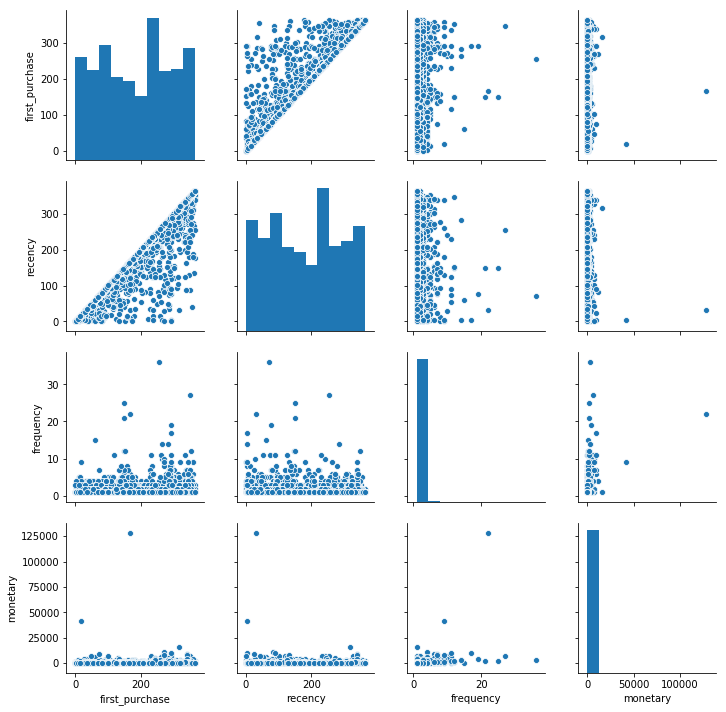

In [13]:
# Plot distributions
sns.pairplot(rfm);

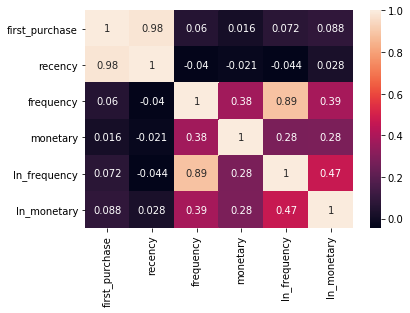

In [15]:
# Investigate multicolinearity
sns.heatmap(rfm.corr(), annot=True);

In [17]:
# Monetary value of outliers
display((ext_summary['monetary'][1].sum() / rfm['monetary'].sum()).round(3))

0.072

### 3.1 Data Preparation Discussion
There are 12028 transactions, 9962 customers and no missing values in the dataset.

It seems that google merchandise store:
 - is slightly growing new customers from a serious drop-out of 200 days ago (present means 1st Aug 2017)
 - was doing extremely well in the number of customers purchasing goods 220-240 days ago
 - but is not doing well on keeping customers as >75% of them purchased only one time

#### 3.1.1 Multicollinearity
`first_purhase` and `recency` are highly collinear which inflates the importance of time dimension over frequency and monetary value and can negatively affect the forming of clusters. I decided to exclude `first_purchase` from the analysis.

#### 3.1.2 Distributions
`first_purchase` and `recency` are uniformly or multimodal distributed. `frequency` approximate exponential and `monetary` chi-square distribution. As these are highly skewed distributions both variables are transformed using natural logarithm: $x_{tr} = ln(x+1)$. The transformation will reduce the number of outliers and enable the clustering algorithm to form more homogenous clusters with more equal sizes.

#### 3.1.3 Outliers
Multivariate dissimilarity has been used to identify outlier customers from the average customer. While raw data shows 1 outlier with a huge customer monetary value of 128K$. Even if this is outlier it needs to be kept in the dataset as it represents 7.2% of total revenue.

Using transformation shows no outliers but 8 underrepresented customers in the population, who need to be kept in the dataset.

In [18]:
# Randomly split data into two sets, and keep outliers in each set
# -----------------------------------------------------------------

# Make results deterministic
random_state=1

# Select variables
X = rfm.drop(columns=['first_purchase'])
for idx_name, idx in idxs.items():
    idxs[idx_name] = idx.drop('first_purchase', errors='ignore')

# Split datasets
threshold = 10
X_names = ['train', 'test']
size = 0.5
Xs = helper.split_data(X, idxs['transformed'], X_names, threshold, 
                       test_size=size, random_state=random_state)

for X_name, X in Xs.items():
    print('Dataset', X_name, 'of shape', X.shape)

Dataset train of shape (4984, 5)
Dataset test of shape (4984, 5)


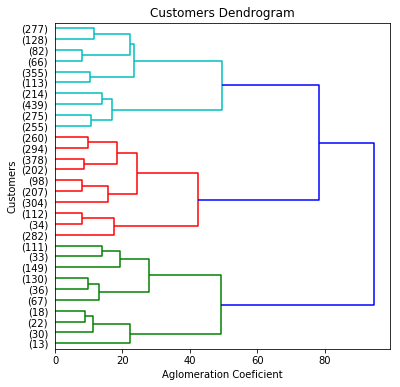

In [19]:
# BUILD AND OPTIMIZE MODEL FOR 1st DATASET
# ----------------------------------------

# Standardize datasets
scalers={}
Xs_std = {}
idxs['all_inputs'] = pd.Index([
    'recency', 'frequency', 'monetary', 'ln_frequency', 'ln_monetary', 
    'recency_std', 'frequency_std', 'monetary_std','ln_frequency_std', 
    'ln_monetary_std'
])

for X_name, X in Xs.items():
    scalers[X_name] = StandardScaler().fit(X)
    Xs_std[X_name] = scalers['train'].transform(X)
    Xs_std[X_name] = pd.DataFrame(Xs_std[X_name], 
                                  columns=Xs[X_name].columns+'_std', 
                                  index=Xs[X_name].index)
    Xs[X_name] = (pd.concat([Xs[X_name], Xs_std[X_name]], axis=1)
                  .reindex(idxs['all_inputs'], axis=1))

# Agglomerative Clustering with average linkage
idxs['transformed_std'] = pd.Index(
    ['recency_std', 'ln_frequency_std', 'ln_monetary_std'])

agl_cluster = linkage(Xs_std['train'][idxs['transformed_std']], 'ward')

# Construct dendrogram
plt.figure(figsize=(6, 6))
dn = dendrogram(agl_cluster, p=30, truncate_mode='lastp', orientation='right')
plt.title('Customers Dendrogram')
plt.xlabel('Aglomeration Coeficient')
plt.ylabel('Customers')
plt.show()

In [20]:
# Step 1: Inspect outliers in agglomeration schedule if any
pass

# Step 2: Consider removing outliers if appropriate
pass

# Step 3: Run algomerative clustering again go to step 1
pass

# Note: no outliers

In [21]:
# Determine number of candidate solutions
# ---------------------------------------

# Get aglomeration shedule
agl_schedule = pd.DataFrame(
    agl_cluster,
    columns=['cluster1', 'cluster2', 'coefficient', 'cluster_size'],
    index=pd.Index(range(1, Xs_std['train'].shape[0]), name='stage')
)

# Calculate proportional heterogeneity increase
agl_schedule['num_of_clusters'] = list(reversed(agl_schedule.index))
agl_schedule['prop_heterogeneity_increase'] = (
    agl_schedule['coefficient']
    .diff()
    .shift(periods=-1)
    / agl_schedule['coefficient']
)

# Print last x stages of algomeration schedule
stages = 15
display(agl_schedule[-stages:])

,cluster1,cluster2,coefficient,cluster_size,num_of_clusters,prop_heterogeneity_increase
stage,,,,,,
4969,9918.0,9938.0,15.791009,609.0,15,0.069112
4970,9946.0,9951.0,16.882356,1183.0,14,0.032872
4971,9923.0,9940.0,17.437321,428.0,13,0.053955
4972,9941.0,9943.0,18.378145,1134.0,12,0.042347
4973,9934.0,9950.0,19.156413,293.0,11,0.154451
4974,9930.0,9947.0,22.115149,83.0,10,0.010029
4975,9939.0,9948.0,22.336937,553.0,9,0.043163
4976,9945.0,9958.0,23.301075,1021.0,8,0.047418
4977,9952.0,9955.0,24.405973,1743.0,7,0.141862


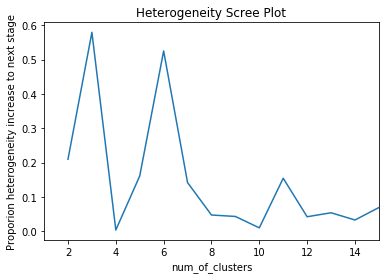

In [22]:
# Print heterogenity scree plot
(agl_schedule
 .set_index('num_of_clusters')
 ['prop_heterogeneity_increase'][-stages:]
 .plot(title='Heterogeneity Scree Plot'))
plt.ylabel('Proporion heterogeneity increase to next stage');

In [23]:
# Selected candidate solutions
num_seeds = [3, 6]

# Profile candiate solutions
# --------------------------

for k in num_seeds:
    
    # Generate candidate solution labels
    labels = fcluster(agl_cluster, k, criterion='maxclust')
    Xs['train']['hierarchic_clusters_{}'.format(k)] = labels
    
    # Display cluster sizes
    display(Xs['train'].groupby('hierarchic_clusters_{}'.format(k))
                       .size()
                       .rename('cluster_sizes'))

display(Xs['train'].head())

hierarchic_clusters_3
1     609
2    2171
3    2204
Name: cluster_sizes, dtype: int64

hierarchic_clusters_6
1      83
2     526
3     428
4    1743
5    1183
6    1021
Name: cluster_sizes, dtype: int64

,recency,frequency,monetary,ln_frequency,ln_monetary,recency_std,frequency_std,monetary_std,ln_frequency_std,ln_monetary_std,hierarchic_clusters_3,hierarchic_clusters_6
client_id,,,,,,,,,,,,
7133939846118520732,257,1,25.99,0.693147,3.295466,0.721933,-0.203508,-0.087949,-0.311743,-0.822272,2,4
6269547197366207744,349,1,164.43,0.693147,5.108548,1.577045,-0.203508,-0.017668,-0.311743,0.783385,2,3
1644471510299169992,200,1,19.99,0.693147,3.044046,0.192136,-0.203508,-0.090995,-0.311743,-1.044929,2,4
4863941202505455588,56,5,2458.15,1.791759,7.807571,-1.146300,3.146721,1.146773,4.424456,3.173627,1,1
2339818672404404924,228,1,173.57,0.693147,5.162326,0.452387,-0.203508,-0.013028,-0.311743,0.831010,3,6


In [25]:
# Revenue overview of 6 cluster solution
monetary_cls_6 = (Xs['train']
                  .groupby('hierarchic_clusters_6', as_index=False)
                  ['monetary']
                  .sum())
monetary_cls_6['prop_monetary'] = (monetary_cls_6['monetary'] 
                                   / Xs['train']['monetary'].sum())
display(monetary_cls_6)

,hierarchic_clusters_6,monetary,prop_monetary
0,1,345467.88,0.347912
1,2,182615.29,0.183907
2,3,134661.19,0.135614
3,4,71226.16,0.071730
4,5,37825.60,0.038093
5,6,221178.24,0.222743


#### 4.3.1.1 Hierarchical Clustering Discussion
##### 4.3.1.1.1 Initial Cluster Results
The dendrogram and agglomeration schedule helps to understand the clustering process. 

The dendrogram shows that indeed natural logarithm transformation of `recency` and `monetary` and __ward method__ have helped to form relatively equal clusters with no outliers. When inspecting solution with 30 clusters the cluster size ranges from 13 to 439 customers. There are no clusters with a single customer which shows algorithm robustness against outliers.

Ex. if the __Average Linkage__ method would be used there would be tree clusters [4977, 4983, 4980] with one customer in later agglomeration stages. It would be necessary to remove those and re-run the algorithm again to reach similar cluster homogeneity and sizes as in __ward method__ case.

_Note:_ To try __Average Linkage__ method just change `ward` to `average` in cell In [17]

##### 4.3.1.1.2 Determining Preliminary Cluster Solutions
Candidate cluster solutions will be specified using __stopping rule__. It is based on assessing the changes in heterogeneity between cluster solutions. The basic rationale is that when a large change in heterogeneity occurs in moving from one stage to the next, the prior cluster solutions should be selected because the next stage is joining quite different clusters. The proportion heterogeneity change to next stage is calculated as: 

$prop\_heterogeneity\_increase_{\text{i}} = \cfrac{coefficient_{\text{i+1}} - coefficient_{\text{i}}}{coefficient_{\text{i}}}$

__Heterogeneity Scree Plot__ shows that the proportionally highest heterogeneity increase is when going from 3 to 2 and 6 to 5 clusters solutions. Therefore two solution candidates with 3 and 6 clusters were further selected for profiling.

##### 4.3.1.1.3 Profiling of Cluster Solutions
Before proceeding to nonhierarchical analysis, the profiling of selected cluster solutions is done to confirm that the differences between customer clusters are distinctive and significant in recency and frequency of purchase and revenue (clustering variables).

Using __one-way ANOVA__ to identify the clustering variable is not practical in this case as ANOVA prerequisites of __residuals normality__ (Shapiro-Wilk Test) and __group variance homogeneity__ (Leven's test) are not met. Instead, nonparametric __Kruskal-Wallis test__ was used to evaluate the overall significance and __post-hoc Nemenyi__ was used to evaluate pair-wise significance.

The results show that there are significant differences between the clusters on all tree variables in both solutions. These provide initial evidence that each of the tree and six clusters solutions are distinctive.

Examination of means of cluster variables shows:
 - tree clusters solution
   - cluster 1 (609 customers) has highest mean on frequency 3.0 and monetary value 867USD representing ___"frequent shopers and high spenders"___
   - cluster 2 (2171 customers) with highest recency 271 days, low frequency 1 most probably representing ___"customer churn"___
   - cluster 3 (2204 customers) with lowest recency 94 days, low frequency 1 represening ___"new customers"___ 
   
 - six clusters solution
   - cluster 1 (83 customers) has highest mean on frequency 7.7 and monetary value 4162USD representing ___"frequent shoppers and huge spenders"___ most probably business customers
   - cluster 2 (526 customers) has second highest mean on frequency 2.3 (no significant diffrence with cluster 1 frequency mean 7.7) and second highest monetary value 347USD representing ___"frequent shoppers and moderate spenders"___
   - cluster 3 (428 customers) has highest recency 319 days, lowest frequency 1 and moderate monetary value 315USD representing ___"moderate spenders churn"___
   - cluster 4 (1743 customers) with 2nd highest recency 259 days, lowest frequency 1 and low monetary value 41USD represening ___"low spenders churn"___
   - cluster 5 (1183 customers) low monetary value 32USD, recency 71 days and frequency 1 representing ___"new low spenders"___
   - cluster 6 (1021 customers) low frequency 1 and moderate monetary value 216USD representing ___"one time moderate spenders"___
   
Both of the solutions will be considered in non-hierarchical analysis due to
 - simplicity and marketing cost efficiency of tree clusters solution, where only 3 strategies need to be developed
 - ability to specify buyer personas with higher granularity, where cluster 1 typology is in center of interest representing only 83 customers who generated 35% (345K USD) of revenue.

### 4.3.2 Nonhierarchical Clustering
Nonhierarchical clustering methods have the advantage of being able to better "optimize" cluster solutions by reassigning observations until maximum homogeneity (similarity) is achieved. This second step in the clustering process uses a number of clusters (seeds) determined in hierarchical clustering. The clustering solutions are then compared to
- how do they generalized on population
- their predictability in respect to additional taxonomy variables (not included in this example)
- applicability to business objective (forming marketing strategies for different buyers personas and best ROI)

#### 4.3.2.1 Seed Points Generation
Tree and six seeds will be used respectively. No random method neither custom selection of centroids will be used. There is no prior business information about RFM characteristics of buyer personas and random method suffers from local optima issue. To cope with this sklearn __K-means++__ initialization method will be used to initialize centroids to be distant from each other, leading to provably better results than random initialization as shown in the [reference](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).

#### 4.3.2.2 Clustering Algorithm
__Optimization algorithm__ will be used. It allows the reassignment of observation among clusters until a minimum level of heterogeneity is reached. Sklearn `KMeans` object's parameter `algorithm='auto'` will determine which algorithm branch to use according to the data structure. `full` for sparse data and `elkan` for dense data. 

In [26]:
# K-mean clustering for selected candidate solutions
kmeans, labels = {}, {}
for k in num_seeds:
    
    # Fit model
    kmeans['non_sorted_{}'.format(k)] = (
        KMeans(n_clusters=k, 
               random_state=random_state, 
               init='k-means++')
        .fit(Xs['train'][idxs['transformed_std']])
    )
    
    # Predict lables
    labels['non_sorted_{}'.format(k)] = (
        kmeans['non_sorted_{}'.format(k)]
        .predict(Xs['train'][idxs['transformed_std']])
    )
    
    Xs['train']['nonhierarchic_clusters_{}'.format(k)] = (
        labels['non_sorted_{}'.format(k)]+1
    )
    
# Display cluster sizes
idxs['nonhierarchic_clusters'] = Xs['train'].columns[
    Xs['train'].columns.str.contains('nonhierarchic_clusters')]

for solution in idxs['nonhierarchic_clusters']:
    display(Xs['train'].groupby(solution)
                      .size()
                      .rename('cluster_sizes')) 

nonhierarchic_clusters_3
1     497
2    2298
3    2189
Name: cluster_sizes, dtype: int64

nonhierarchic_clusters_6
1    1490
2     794
3     494
4     645
5      83
6    1478
Name: cluster_sizes, dtype: int64

PROFILE SUMMARY FOR NONHIERARCHIC_CLUSTERS_3
--------------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean             median             anova_p  \
nonhierarchic_clusters_3     1     2     3      1     2     3           
recency_std              -0.14  0.87 -0.88  -0.23  0.83 -0.90     0.0   
ln_frequency_std          2.37 -0.26 -0.26   1.44 -0.31 -0.31     0.0   
ln_monetary_std           1.57 -0.11 -0.24   1.37 -0.21 -0.37     0.0   

                         levene_p shapiro_wilk_p kruskal_wallis_p  
nonhierarchic_clusters_3                                           
recency_std                   0.0            0.0              0.0  
ln_frequency_std              0.0            0.0              0.0  
ln_monetary_std               0.0            0.0              0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



clustering variable: ln_frequency_std


,1,2,3
1,-1,0,0
2,0,-1,1
3,0,1,-1



clustering variable: ln_monetary_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



Profile vizualization
----------------------


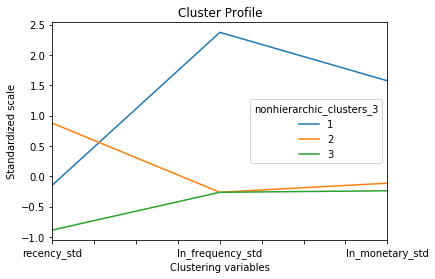


Clusters vizualization
-----------------------


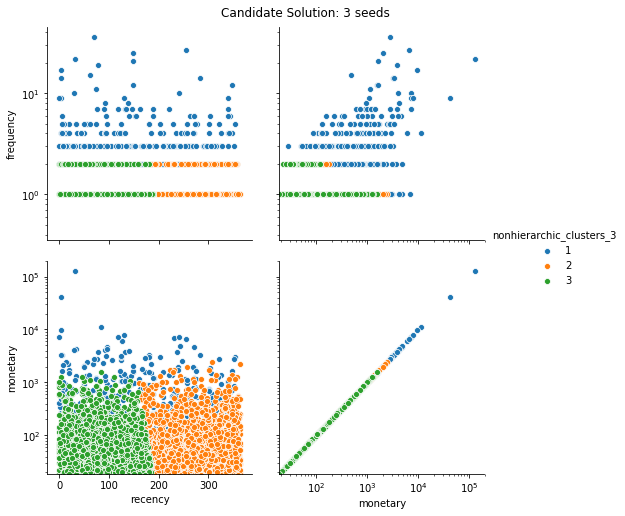

Profile characteristics
-----------------------


mean                     median                 
                         frequency monetary recency frequency monetary recency
nonhierarchic_clusters_3                                                      
1                              3.2   1129.4   163.8         2    320.9     155
2                              1.0    105.3   273.3         1     52.7     269
3                              1.0     86.7    84.2         1     44.2      83



PROFILE SUMMARY FOR NONHIERARCHIC_CLUSTERS_6
--------------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean                               median        \
nonhierarchic_clusters_6     1     2     3     4     5     6      1     2   
recency_std              -0.95  1.07 -0.12 -0.72 -0.18  0.75  -0.96  1.13   
ln_frequency_std         -0.30 -0.30  1.75 -0.31  5.47 -0.30  -0.31 -0.31   
ln_monetary_std          -0.60  0.67  1.04  0.96  2.75 -0.67  -0.56  0.49   

                                                 anova_p levene_p  \
nonhierarchic_clusters_6     3     4     5     6                    
recency_std              -0.14 -0.72 -0.30  0.66     0.0      0.0   
ln_frequency_std          1.44 -0.31  5.09 -0.31     0.0      0.0   
ln_monetary_std           0.93  0.76  2.61 -0.63     0.0      0.0   

                         shapiro_wilk_p kruskal_wallis_p  
nonhierarchic_clusters_6                                  
recency_std                         0.0              0.0  
ln_frequency_std                    0.0              0.0  
ln_monetary_std                     0.0              0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3,4,5,6
1,-1,0,0,0,0,0
2,0,-1,0,0,0,0
3,0,0,-1,0,1,0
4,0,0,0,-1,0,0
5,0,0,1,0,-1,0
6,0,0,0,0,0,-1



clustering variable: ln_frequency_std


,1,2,3,4,5,6
1,-1,1,0,1,0,1
2,1,-1,0,1,0,1
3,0,0,-1,0,0.09,0
4,1,1,0,-1,0,1
5,0,0,0.09,0,-1,0
6,1,1,0,1,0,-1



clustering variable: ln_monetary_std


,1,2,3,4,5,6
1,-1,0,0,0,0,0.16
2,0,-1,0.05,0.01,0,0
3,0,0.05,-1,1,0,0
4,0,0.01,1,-1,0,0
5,0,0,0,0,-1,0
6,0.16,0,0,0,0,-1



Profile vizualization
----------------------


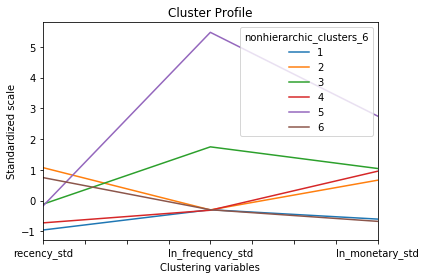


Clusters vizualization
-----------------------


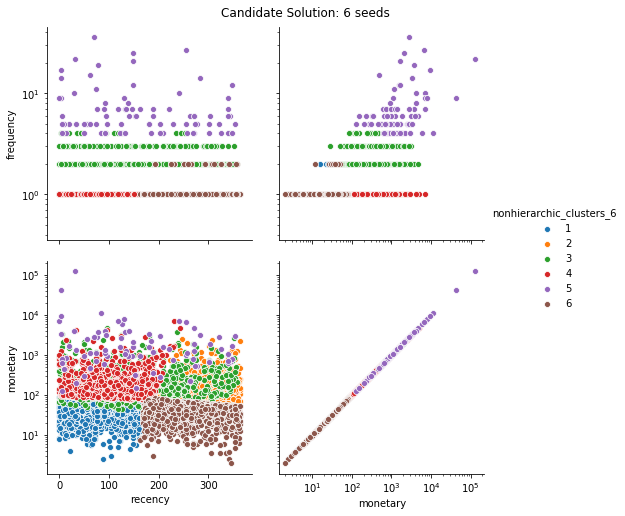

Profile characteristics
-----------------------


mean                     median                 
                         frequency monetary recency frequency monetary recency
nonhierarchic_clusters_6                                                      
1                              1.0     38.6    76.6         1     35.1    76.0
2                              1.0    197.9   294.8         1    118.4   300.5
3                              2.3    368.0   166.9         2    194.0   164.5
4                              1.0    310.3   101.6         1    159.4   102.0
5                              7.7   4156.0   160.5         6   1300.9   147.0
6                              1.0     34.8   260.0         1     32.4   250.0

In [27]:
# Test candidate solutions
# ---------------------------

# Execute cluster profile tests, print cluster profiles & scatterplots
for solution in idxs['nonhierarchic_clusters']:
    summary, post_hoc, prof_ax, clst_pg = (
        helper.analyze_cluster_solution(
            Xs['train'], idxs['transformed_std'], 
            solution, post_hoc_fnc=post_hoc_test
        )
    )
    
    # Print original variable means and averages per cluster
    str_ = 'Profile characteristics'
    print(str_ + '\n' + '-' * len(str_))

    display(Xs['train']
            .groupby(solution)
            [idxs['original']]
            .agg(['mean', 'median'])
            .round(1)
            .swaplevel(axis=1)
            .sort_index(level=0, axis=1))
    
    print('\n')

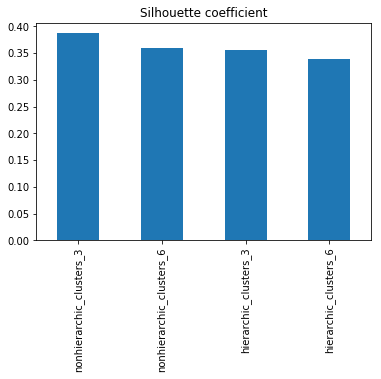

nonhierarchic_clusters_3    0.387130
nonhierarchic_clusters_6    0.359633
hierarchic_clusters_3       0.354846
hierarchic_clusters_6       0.339845
Name: silhouette_score, dtype: float64

In [28]:
# Evaluate within clusters homogeneity and 
# between clusters heterogeneity using Silhouette coeficient
idxs['clusters'] = Xs['train'].columns[
    Xs['train'].columns.str.contains('clusters')]

score = pd.Series(index=idxs['clusters'], name='silhouette_score')

for k, solution in zip(num_seeds * 2, idxs['clusters']):
    score[solution] = silhouette_score(Xs['train'][idxs['transformed_std']],
                                       Xs['train'][solution], 
                                       random_state=random_state)
# Diplay overview
score = score.sort_values(ascending=False)
score.plot.bar(title = 'Silhouette coefficient')
plt.show()
display(score)

In [29]:
# initiate buyer personas names
cluster_names = {3: ['frequent shoppers and high spenders',
                     'customer churn',
                     'new customers'],
                 6: ['new low spenders',
                     'moderate spenders churn',
                     'frequent shoppers and moderate spenders',
                     'one time moderate spenders',
                     'frequent shoppers and huge spenders',
                     'low spenders churn']}

## 5. Evaluation
The purpose of this section is to assess if generalizability of the solution to the population.

### 5.1 Clusters Stability
Factors such as initial seed points, observation ordering can effect cluster membership in nonhierarchical clustering. To check the stability of the clusters, the dataset is sorted by monetary value and compared with the original 3 and 6 cluster solutions.Solutions are cross-tabulated for comparison of miss-matched cluster membership where the following rules are applied:

| Cluster Stability 	| Missmatch in % 	|
|-------------------	| ----------------	|
| very stable       	|     <0-10>     	|
| stable            	|     (10-20>    	|
| somewhat stable   	|     (20-25>    	|
| not stable        	|       >25      	|

___Note___: Clusters numbers may not correspond to each other across different algorithms and differently sorted datasets. Therefore do not expect the highest numbers on the diagonal of the confusion matrix. Matching of the clusters needs to be doublechecked visually on scatterplots.

### 5.1.1 Clusters Stability Discussion
The 3 and 6 cluster solution is stable as membership mismatched is in range <10-20%) (11%, 16% respectively). The 6 cluster solution showed 38% mismatched for label 6. There is a possibility to improve the stability of 6 cluster solutions by selecting custom center points, but this would need to be supported by prior business information.

## 5.2 Clusters Generalizability
Clustering methods belong to unsupervised machine learning algorithms, so there are no ground truth labels to calculate accuracy to check how the model generalizes to population. The different approaches can be used using cross-tabulation between two solutions and calculating mismatch where the same rules above apply. The following procedure is used: 
 - Data are randomly split by half to `train` and `test` sample.
 - The `train` sample is used to train the first clustering model which needs to be evaluated. 
 - "True" labels are estimated by the second clustering model trained on the `test` sample.  
 - Predicted labels are acquired using `KMeans.predict` function of the first fitted model
 - First model generalizability is evaluated using __confusion matrix__ cross-tabulating "True" and predicted labels

In [31]:
# Validate solution generalizability to whole population
# ------------------------------------------------------
for k in num_seeds:
    
    kmeans['train_{}'.format(k)] = kmeans['non_sorted_{}'.format(k)]
    
    # Fit model on test dataset
    kmeans['test_{}'.format(k)] = (
        KMeans(n_clusters=k, 
               random_state=random_state, 
               init='k-means++')
        .fit(Xs['test'][idxs['transformed_std']])
    )
    
    # Predict lables with model fitted on test dataset
    labels['test_true_{}'.format(k)] = (
        kmeans['test_{}'.format(k)]
        .predict(Xs['test'][idxs['transformed_std']])
    )
    
    Xs['test']['true_clusters_{}'.format(k)] = (
        labels['test_true_{}'.format(k)] + 1
    )

    # Predict lables with model fitted on train dataset
    labels['test_predicted_{}'.format(k)] = (
        kmeans['train_{}'.format(k)]
        .predict(Xs['test'][idxs['transformed_std']])
    )
    
    Xs['test']['predicted_clusters_{}'.format(k)] = (
        labels['test_predicted_{}'.format(k)] + 1
    )
    
    # Cross tabulation
    cross_tab, missmatch, total_missmatch = helper.get_missmatch(
        index=Xs['test']['true_clusters_{}'.format(k)],
        columns=Xs['test']['predicted_clusters_{}'.format(k)],
        rownames=['true'],
        colnames=['predicted']
    )

    print(cross_tab,'\n')
    print(missmatch, '\n')
    print('Total missmatch proportion: {:.2f}\n\n\n'.format(total_missmatch))

predicted    1     2     3
true                      
1            0  2307    14
2            0     1  2168
3          440    30    24 

true
1    0.006032
2    0.000461
3    0.109312
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.01



predicted     1    2    3    4   5     6
true                                    
1             0   71    0    0   0  1427
2             0    5  475    0   4     0
3          1337    0    0    0   0    29
4             0    0    0    0  46     0
5             0  764    0   39   0     9
6           164    0    0  612   0     2 

true
1    0.047397
2    0.018595
3    0.021230
4    0.000000
5    0.059113
6    0.213368
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.06





### 5.2.1 Discussion on Clusters Generalizability
The 3 cluster solution generalizes very well to the population with 1% clusters membership mismatch (Accuracy Error). The 6 cluster solution generalizes well with 6% error. It is acceptable to profile and compare both solutions on additional nonclustering variables.

In [32]:
# Predict cluster labels for whole dataset
# ----------------------------------------

# Standardize data
X = rfm.drop(columns=['first_purchase'])
X_std = scalers['train'].transform(X)
X_std = pd.DataFrame(X_std, 
                     columns=X.columns+'_std', 
                     index=X.index)
X = (pd.concat([X, X_std], axis=1)
              .reindex(idxs['all_inputs'], axis=1))

# Predict labels
labels = {}
for k in num_seeds:
    labels[k] = (kmeans['train_{}'.format(k)]
                 .predict(X[idxs['transformed_std']]))
    
    X['clusters_{}'.format(k)] = labels[k] + 1

y_pred = X[X.columns[X.columns.str.contains('clusters')]]
display(y_pred)

,clusters_3,clusters_6
client_id,,
0000213131142648941,3,1
0002871498069867123,2,2
0003450834640354121,2,6
0003961110741104601,3,1
000435324061339869,2,6
...,...,...
9991633376050115277,3,1
9994767073213036303,2,2
9997409246962677759,2,6


## 5.3 Profiling Cluster Solution on Additional Variables
The profiling stage involves describing the characteristics of each buyer persona (cluster) to explain how it may differ in relevant dimensions as demographics, consumption patterns and behaviors. These are the variables not included in cluster analysis. This section provides an answer to the second question: What are the unique characteristics of buyer personas?

### 5.3.1 Data Understading

#### 5.3.1.1 Data Understanding Discussion
Additional variables are queried on product level which is equivalent to the item level of each customer order. There are 36558 item records and 46 variables, where 30 are nominal, 2 are binary, 9 are numeric, 4 are identifiers (session_id is composite_id made during query) and 1 is DateTime.

3 numeric variables `visits`, `social_interactions`, `unique_social_interactions` are constant and does not add useful information and will be deleted. 2 nominal variables `social_action` and `social_interaction_network` are 100% missing and will be deleted.

### 5.3.2 Data Preparation
Then following data handling is applied:
 1. Missing values are handled by deleting variables and cases with a high proportion of missing values
 2. Variables with a low proportion of missing values are reengineered from other relevant variables
 3. Nominal variables are one-hot encoded
 4. Variables are aggregated on client_id level, during aggregation some new additional variables are engineered.

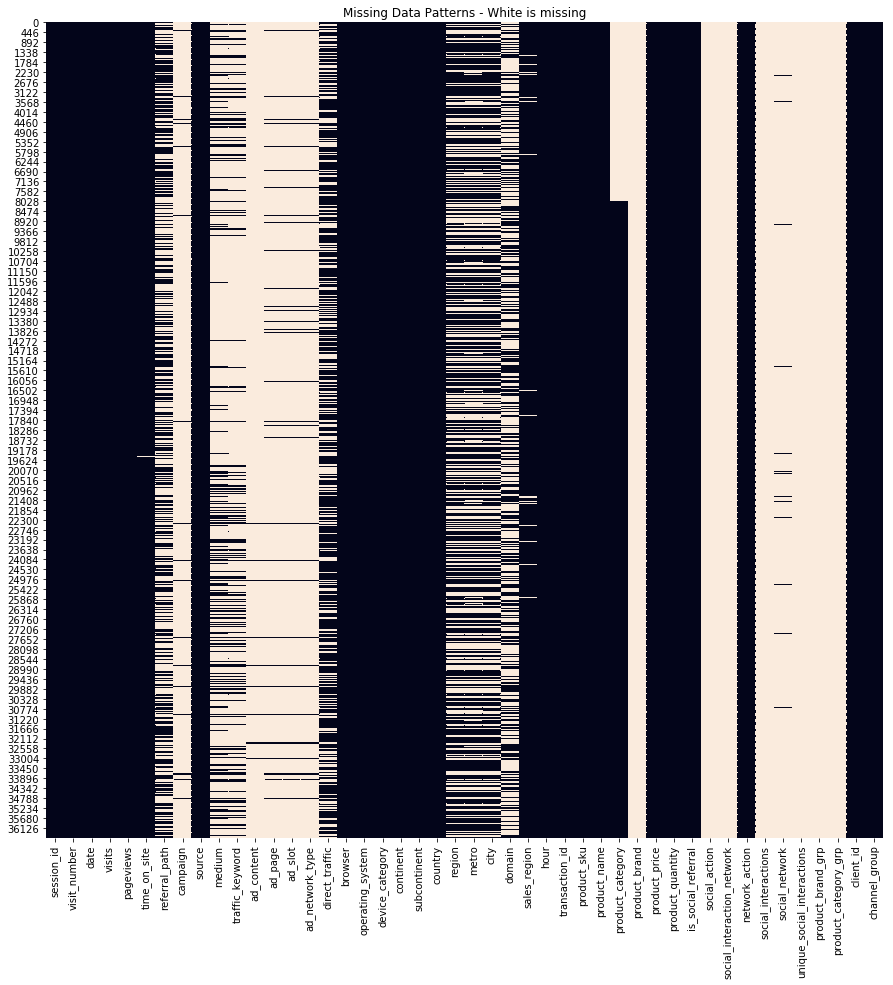

In [34]:
# HANDLE MISSING VALUES
# ---------------------

# Plot missing values patterns
nan_chars = {'nan',
             'None',
             '(none)',
             '(not set)',
             'not available in demo dataset'}
             
nan_mask = (df.isna() 
            | df.isnull() 
            | (df == 'nan')
            | (df == 'None')
            | (df == '(none)') 
            | (df == '(not set)') 
            | (df == 'not available in demo dataset'))
plt.figure(figsize=(15, 15))
ax = sns.heatmap(nan_mask, cbar=False);
plt.title('Missing Data Patterns - White is missing')
plt.show()

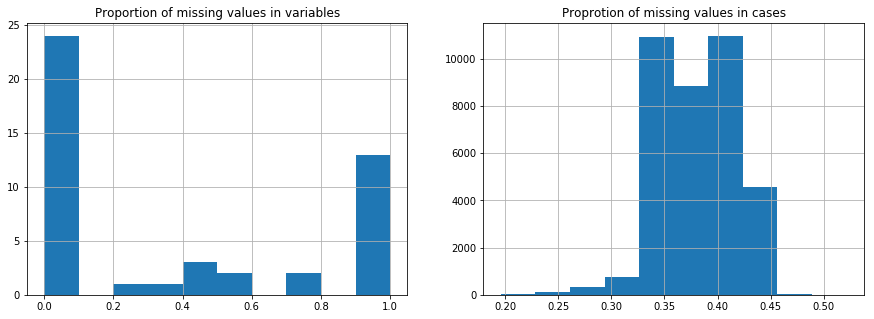

In [35]:
# Plot missing values proportion across variables and cases
nan_prop_vars = ((nan_mask.sum() / nan_mask.index.size)
                 .rename('proprotion of missing values in variables')
                 .sort_values(ascending=False))

nan_prop_cases = ((nan_mask.sum(axis=1) / nan_mask.columns.size)
                 .rename('proprotion of missing values in cases')
                 .sort_values(ascending=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
nan_prop_vars.hist(ax=ax1)
ax1.set_title('Proportion of missing values in variables')
nan_prop_cases.hist(ax=ax2)
ax2.set_title('Proprotion of missing values in cases');

In [37]:
# FEATURE ENGINEERING
# -------------------
re_engineered_vars = ['traffic_keyword',
                      'product_brand',
                      'product_category',
                      'sales_region',
                      'avg_visits',
                      'avg_pageviews',
                      'avg_time_on_site',
                      'social_referral',
                      'ad_campaign',
                      'avg_product_revenue',
                      'avg_unique_products']

# Reconstruct traffic variables
# -----------------------------
df['traffic_keyword'] = (df['traffic_keyword']
                         .astype(object)
                         .apply(helper.reconstruct_traffic_keyword)
                         .astype('category'))

# Engineer brand variable from brand keywords in product name
# and brand variables. Remaining (not set) brand is Google brand
# --------------------------------------------------------------
product_df = helper.query_product_info(client, query_params)
df['product_brand'] = (helper.reconstruct_brand(df['product_sku'], product_df)
                       .astype('category'))

# Engineer category labels from category variables and keywords in product name.
# Remaining (not set) brand is predicted by Naive Bayes Model with 
# f1 weighted test score > 0.8% (0.985)
# ------------------------------------------------------------------------------

# load mappings from category variables to category_label
product_category = (
    pd.read_excel('product_categories.xlsx', 
                  sheet_name='product_category_id')
    [['product_category', 'category_label']]
)

product_category_grp = pd.read_excel('product_categories.xlsx', 
                                        sheet_name='product_category_grp_id')

category_spec = {'product_category': product_category,
                 'product_category_grp': product_category_grp}

# reconstruct category labels from category variables and product names
df['product_category'] = (
    helper.reconstruct_category(df['product_sku'], product_df, category_spec)
    .astype('category')
)

# reconstruct sales region from subcontinent labels
# -------------------------------------------------
df['sales_region'] = (df['subcontinent']
                       .apply(helper.reconstruct_sales_region)
                       .astype('category'))

# cast binary variable is_social_referral
df['social_referral'] = ((df['is_social_referral']
                          .replace(['Yes', 'No'], [True, False]))
                          if df['is_social_referral'].dtype != 'bool'  
                          else df['is_social_referral'])

# create ad campaign flag from campaign and add variables
ad_vars = ['campaign', 'ad_content', 'ad_page', 'ad_slot', 'ad_network_type']
df['ad_campaign'] = False
df.loc[~nan_mask[ad_vars].all(axis=1), 'ad_campaign'] = True

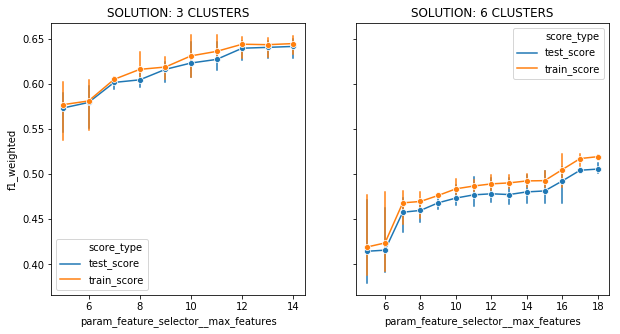

In [40]:
# fine tune selected classifiers
# ------------------------------
# Cycle over cluster solutions
pipe, grid_search = {}, {}
max_features = [
    np.arange(5, 15, 1),
    np.arange(5, 19, 1)
]
fig, axes = plt.subplots(
    1, len(num_seeds), figsize=(10, 5), sharey=True
)
for i, (ax, k, num_features) in enumerate(zip(
    axes.flatten(), num_seeds, max_features)):
    
    # set pipeline
    pipe_steps = [
        ('preprocessor', StandardScaler()),
        ('feature_selector',
         SelectFromModel(
             RandomForestClassifier(
                 n_jobs=-1, 
                 random_state=random_state
            ),
            threshold = -np.inf
         )
        ),
        ('classifier', None)
    ]
    
    pipe[k] = Pipeline(pipe_steps)

    # set grid_search
    param_grid = {
        'feature_selector__max_features': num_features,
        'classifier': [
            LinearSVC(random_state=random_state, dual=False)
        ]
    }
    
    grid_search[k] = GridSearchCV(
        estimator=pipe[k], 
        param_grid=param_grid, 
        scoring='f1_weighted',
        n_jobs=-1,
        return_train_score=True
    )

    # run screening
    title = 'SOLUTION: {} CLUSTERS'.format(k)
    plt.sca(ax)
    grid_search[k] = helper.screen_model(
        X_train, 
        X_test,        Y_train['clusters_{}'.format(k)], 
        Y_test['clusters_{}'.format(k)],
        grid_search=grid_search[k],
        fine_param='param_feature_selector__max_features',
        title=title,
        verbose='plot'
    )